In [1]:
import pandas as pd

In [47]:
df = pd.read_csv(r"C:\Users\solharsh\Desktop\Data Science\Dataset\Alexa Dataset.csv")

In [48]:
df.head()

,text,domain,intent
0,play neos by glacier,Music,PlayMusicIntent
1,cancel the twenty five minute timer,Other,CancelNotificationIntent
2,what time is it,Global & Other,WhatTimeIntent
3,turn the music up,Global & Other,VolumeUpIntent
4,play earth wind and fire pandora,Music,PlayStationIntent


In [49]:
df['domain'].unique()

array(['Music', 'Other', 'Global & Other', 'Smart Home', 'Lists',
       'Knowledge', 'Weather', 'Personality', 'Skills Management',
       'Video', 'Notification Service'], dtype=object)

It is important to know the distribution of data. We will try to classify domain, so let's plot the number of records for each domain.

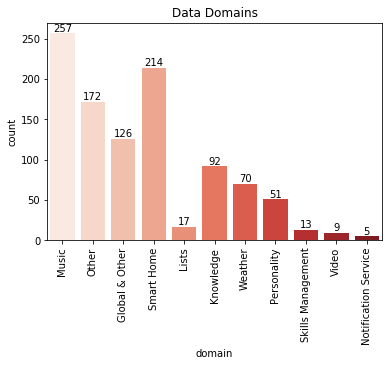

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=df["domain"], y = None, palette = "Reds")
plt.xticks(rotation=90)
plt.title('Data Domains')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), ha='center', va='bottom') 
plt.show()

A quick look at this plot will reveal that the dataset is __imbalanced__. We will address that issue when we are fitting our neural network. 

# Pre-processing, TF-IDF and Class Weights

    Lemmatize the text data
    Use TF-IDF features
    Convert labels into classes (We will use on-hot-encoding)
    Calculate class weights (due to imbalanced dataset)

In [51]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.utils import class_weight

# Let's create a small function to return word tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# NLTK libraries we need for this problem.
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.data.path.append(r"C:\Users\solharsh\Desktop\Data Science\Dataset")

# Lemmatize the text column.
wl = WordNetLemmatizer()
df["text"] = df["text"].apply(lambda x: ' '.join([wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in nltk.pos_tag(word_tokenize(x))]))

# Take TF-IDF features
vectorizer = TfidfVectorizer()
text_tf_idf = vectorizer.fit_transform(df["text"])

# We have 11 classes (domain column) in this problem.
num_classes = 11

# We will first use numbers for each domain class
# "Music" => 0, "Other" => 1
le = preprocessing.LabelEncoder()
le.fit(df['domain'].values)
labels = le.transform(df['domain'].values)

# Let's calculate class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(labels), labels)

# Let's convert labels to one-hot codes. Such as:
# 3 => 0 0 1 0 0 0 0 0 0 0 0 
# 7 => 0 0 0 0 0 0 7 0 0 0 0

one_hot_encoder = lambda t: np.squeeze(np.eye(num_classes)[t.reshape(-1)])
labels = one_hot_encoder(labels)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\solharsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\solharsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\solharsh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [53]:
from sklearn.model_selection import train_test_split

# Let's split the data (5% test, 95% training)
X_train, X_test, y_train, y_test = train_test_split(text_tf_idf, labels, test_size=0.20, random_state=200)

# Building the model

We will use a two layer neural network. Different number of units and layers can be tried.

In [54]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

model = Sequential()
model.add(Dense(64, activation = 'relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(11, activation='softmax'))

## Compiling the model
We will select our loss, metrics and optimizer and compile the model. In this example, we used Stochastic Gradient Descent (sgd) optimizer, Categorical Cross-Entropy loss and accracy metric. 

In [55]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

## Training the model
After model is compiled, it is time to train it. In this example, we train the network for 12 epochs (full pass over the dataset) with batch size 4. This will take some time to finish. It will print training and validation results for each epoch. Here we passed our test data to the validation_data parameter. Another important thing to consider here is class weights. Similar to logistic regression, we calculated the class weights and pass to fit function here. 

In [57]:
history = model.fit(X_train.toarray(), y_train, epochs=50, batch_size=4, verbose=2, validation_data=(X_test.toarray(), y_test), class_weight=class_weights)

Train on 820 samples, validate on 206 samples
Epoch 1/50
 - 1s - loss: 1.1727 - accuracy: 0.6390 - val_loss: 1.0375 - val_accuracy: 0.6893
Epoch 2/50
 - 0s - loss: 1.1174 - accuracy: 0.6573 - val_loss: 0.9726 - val_accuracy: 0.7427
Epoch 3/50
 - 1s - loss: 1.0448 - accuracy: 0.6756 - val_loss: 0.9008 - val_accuracy: 0.7573
Epoch 4/50
 - 0s - loss: 0.9774 - accuracy: 0.6939 - val_loss: 0.8567 - val_accuracy: 0.7816
Epoch 5/50
 - 0s - loss: 0.9107 - accuracy: 0.7256 - val_loss: 0.8115 - val_accuracy: 0.7961
Epoch 6/50
 - 1s - loss: 0.8608 - accuracy: 0.7512 - val_loss: 0.7783 - val_accuracy: 0.7961
Epoch 7/50
 - 1s - loss: 0.8200 - accuracy: 0.7756 - val_loss: 0.7397 - val_accuracy: 0.7961
Epoch 8/50
 - 0s - loss: 0.7711 - accuracy: 0.7793 - val_loss: 0.7195 - val_accuracy: 0.8155
Epoch 9/50
 - 0s - loss: 0.7517 - accuracy: 0.7866 - val_loss: 0.6823 - val_accuracy: 0.8350
Epoch 10/50
 - 0s - loss: 0.7014 - accuracy: 0.8122 - val_loss: 0.6457 - val_accuracy: 0.8204
Epoch 11/50
 - 1s - los

## Visualizing results
Let's see the results of our training. Using the history variable from the keras fit() function, we can plot the result of our training. 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


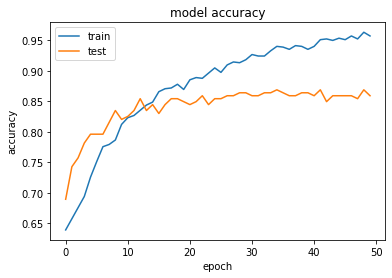

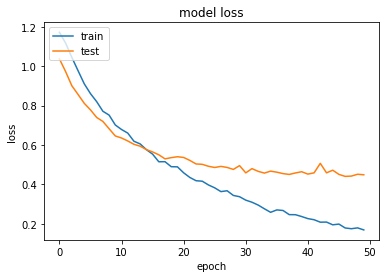

In [58]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Confusion Matrix:
Although we plotted the training result. It is also useful to see the confusion matrix. 

[ 3  5  3  3  5  0  1  0  8  8  3 10  8 10  0  3  8  3 10  8  3  3 10  8
  3 10  0  1  1  0  1  8  3  3  1  1  8  3  3  8  0  3  8  3  3  8  3  3
  1  5  3  1  8  0  8  1  3  5 10  0  0  3  6  5  8  8  3 10  3  8  8  1
  1  3  3  0  3  3  5  3  5  8  8  3  5  3  3  5  8  8  3  5  0  3  0  5
  8  5  5  5  6  2  8  3  3  5 10 10 10  0  5  5  3  8  3  3  0  3  8  6
  1  1  3 10  8  3  1  3 10  3  5 10 10  6  3  1  8  5  8  5  3  5  5  3
  1 10  0  8  3  8  5  6  0  0  0  1  0  8  8  3  3  5  6  5  3  0  5  5
  8  8  3  3  3  8  3  3  8  5  3  3  1  0  3  3  8  8  5 10  1  3  3  0
  3  8  8  3  3  3  8  0  3  8  1  1  5  2]


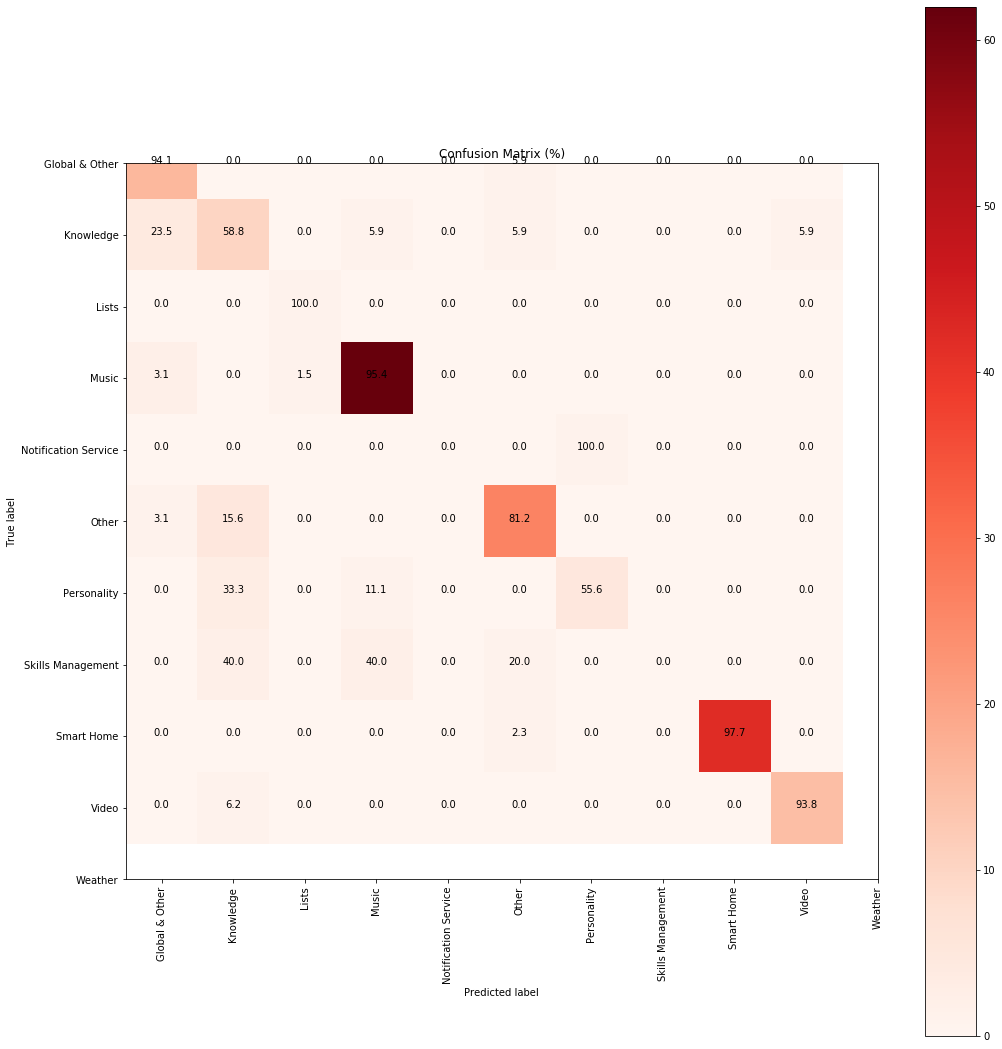

In [59]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

y_pred = model.predict(X_test.toarray())

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

classes = np.unique(df['domain'].values)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("Confusion Matrix (%)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]*100, '.1f'),
            horizontalalignment="center",
            color="black" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()

We can see above that the model doesn't perform well for "Skill management", "Personality", "Knowledge" and "Notification services" categories.

But, that was expected due to size of the dataset